# Imports

In [1]:
import pandas as pd
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast

In [2]:
video_resolution = (128, 128)
num_frames = 10
lr = 0.001

batch_size = 24
epochs = 10

device = "cuda:0"
ngpu = 1

In [14]:
DATASET_PATH = "/media/marc/D/Deepfake Dataset/dfdc_train_all"
all_data = pd.DataFrame()

# Iterate over each folder in the dataset
for folder in os.listdir(DATASET_PATH):
    # Construct the path to the metadata file
    metadata_path = os.path.join(DATASET_PATH, folder, "metadata.json")
    if os.path.exists(metadata_path):
        # Load the metadata file
        with open(metadata_path, "r") as file:
            data = json.load(file)
            # Add the metadata to the dataframe
            df = pd.DataFrame.from_dict(data, orient='index')
            df["subfolder"] = folder
            all_data = pd.concat([all_data, df], ignore_index=False)

# Sort the dataframe by the subfolder
all_data = all_data.sort_values("subfolder")
all_data.reset_index(inplace=True)
all_data.rename(columns={"index": "filename"}, inplace=True)

print(all_data.head())
print("#######################################################################")
print(all_data.tail())

# check if last two digits represent all datasets from 0 to 49
for i in range(50):
    assert str(i).zfill(2) in all_data["subfolder"].str[-2:].values, f"Dataset {i} is missing"

print(all_data.shape)

         filename label  split        original           subfolder
0  zpbggelffo.mp4  FAKE  train  eppyqpgewp.mp4  dfdc_train_part_00
1  hvlqewtbbf.mp4  FAKE  train  rmufsuogzn.mp4  dfdc_train_part_00
2  ojayvjcdna.mp4  FAKE  train  fdpisghkmd.mp4  dfdc_train_part_00
3  huznbaakma.mp4  FAKE  train  rktrpsdlci.mp4  dfdc_train_part_00
4  biatmogsbv.mp4  FAKE  train  uprwuohbwx.mp4  dfdc_train_part_00
#######################################################################
              filename label  split        original           subfolder
119141  csoxekulpu.mp4  FAKE  train  nggrodpfsn.mp4  dfdc_train_part_49
119142  ksezqktegk.mp4  FAKE  train  kbdwudhhwf.mp4  dfdc_train_part_49
119143  kfntzsnaeu.mp4  REAL  train             NaN  dfdc_train_part_49
119144  jlxnzxtopm.mp4  REAL  train             NaN  dfdc_train_part_49
119145  vlcnvhanxr.mp4  FAKE  train  kvhbyuklfv.mp4  dfdc_train_part_49
(119146, 5)


# Data Preprocessing

In [4]:
def preprocess_video(video_path, output_dir, height=128, width=128, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    flows = [] # Optical flow

    prev_frame = None
    frame_count = 0
    while frame_count < num_frames:
        ret, frame = cap.read() # Read the next frame
        if not ret:
            break

        frame = cv2.resize(frame, (width, height))

        if prev_frame is not None:
            flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY),
                                                cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), None, 0.5, 3, 15, 3, 5, 1.2, 0) # Calculate optical flow
            flows.append(flow)

            # Normalize and save the optical flow immediately after computation
            max_flow = np.max(flow)
            min_flow = np.min(flow)
            if max_flow == min_flow: # Prevent division by zero
                flow = np.zeros_like(flow)
            else:
                flow = 2 * (flow - min_flow) / (max_flow - min_flow) - 1 
            np.save(os.path.join(output_dir, f"flow_{frame_count-1}.npy"), flow)

        frames.append(frame)
        prev_frame = frame

        # Normalize and save the frame immediately after computation
        frame = frame / 255.0
        np.save(os.path.join(output_dir, f"frame_{frame_count}.npy"), frame)

        frame_count += 1

    cap.release()

    return frames, flows

/media/marc/D/Deepfake Dataset/dfdc_train_all/dfdc_train_part_00/zpbggelffo.mp4


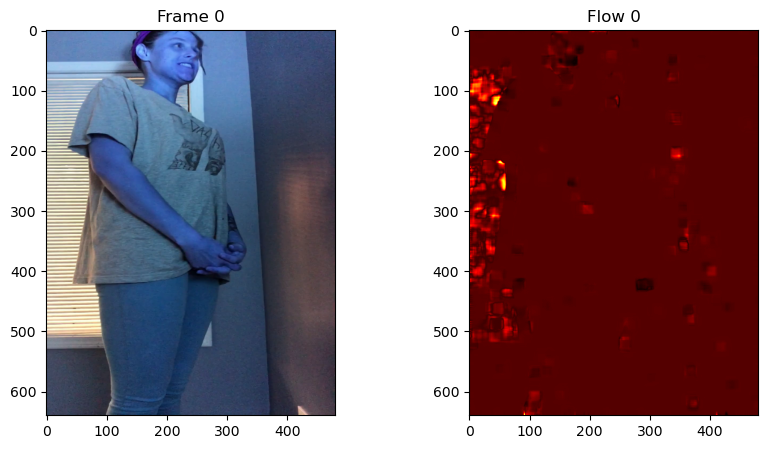

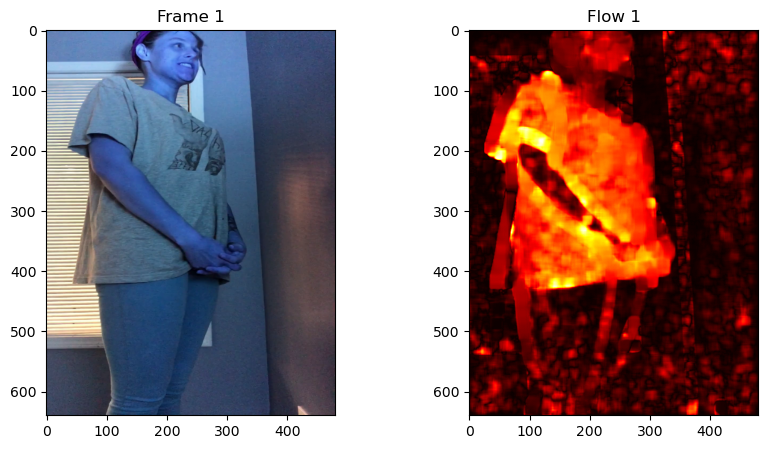

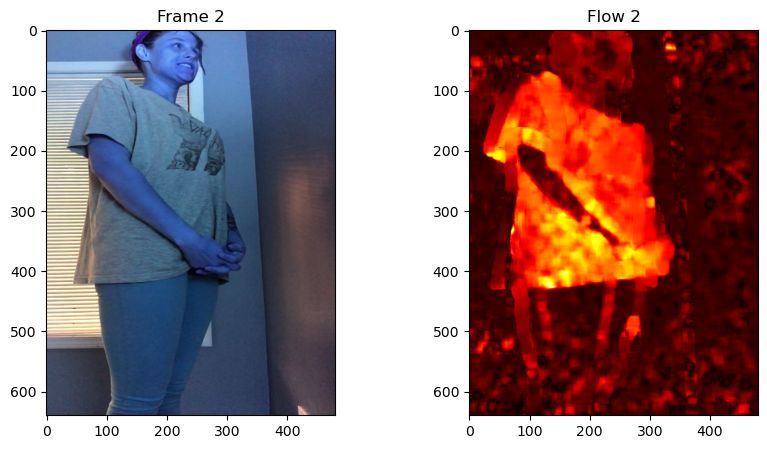

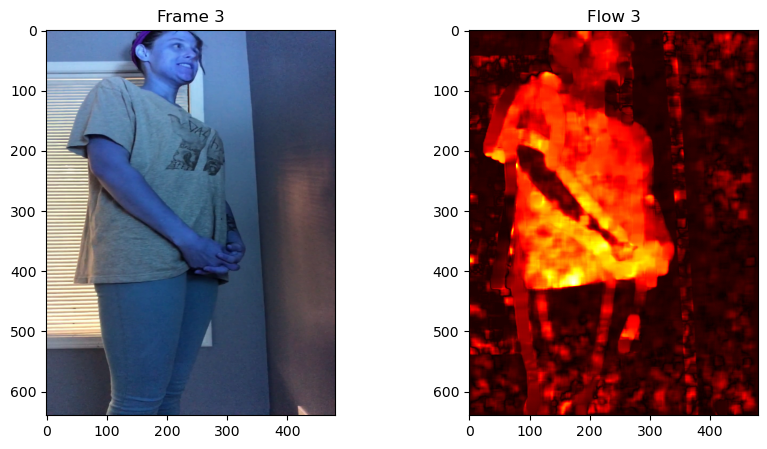

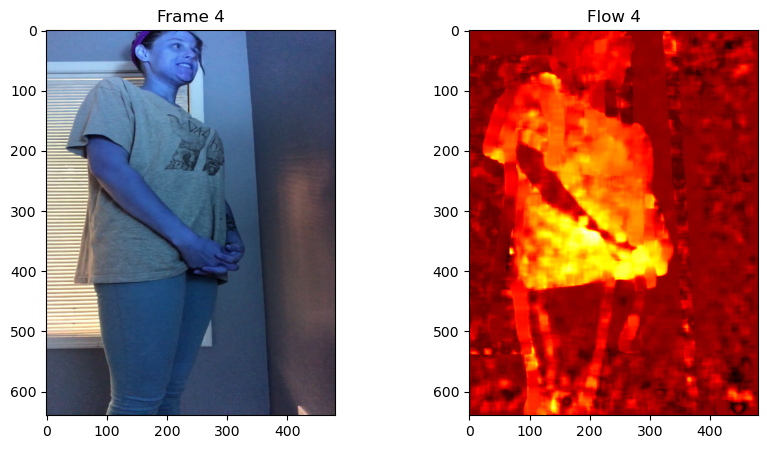

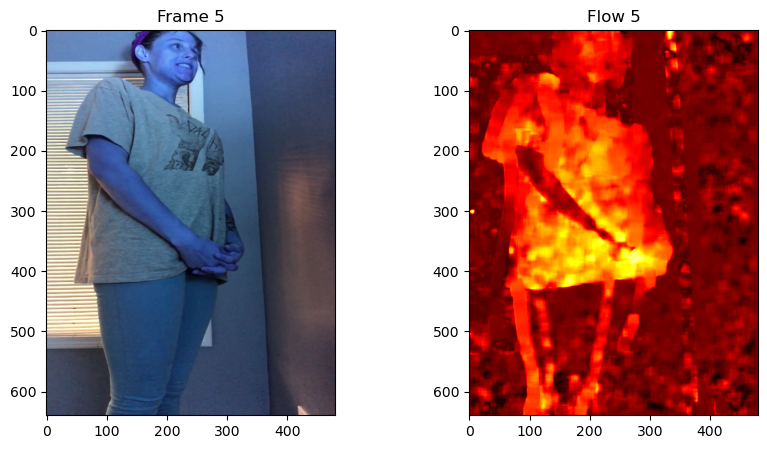

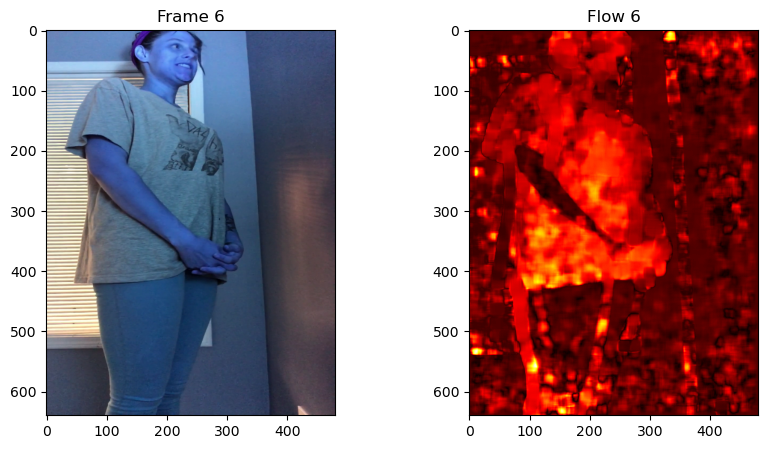

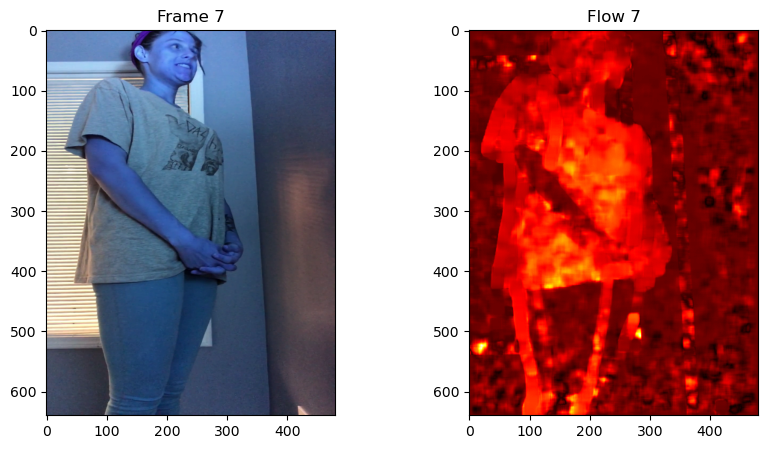

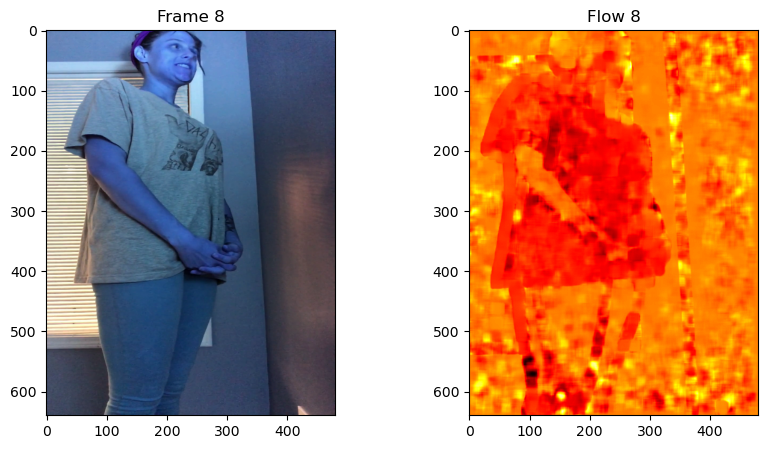

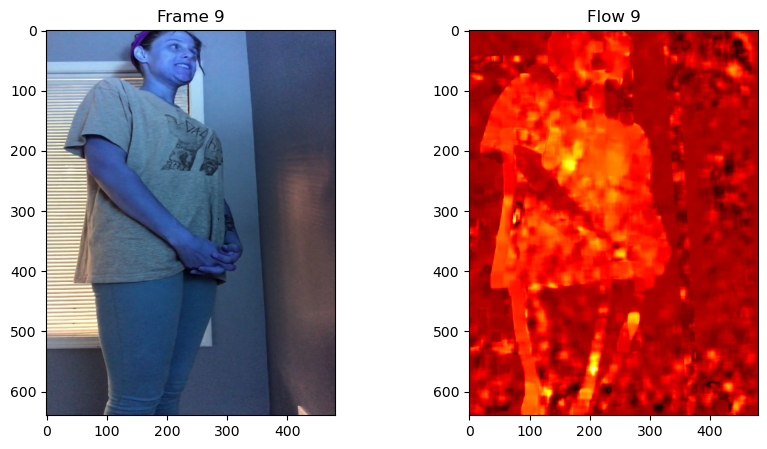

In [5]:
# Test the preprocess_video function
video_path = os.path.join(DATASET_PATH, all_data.iloc[0]["subfolder"], str(all_data.iloc[0]["filename"]))
print(video_path)
output_dir = "/media/marc/D/Deepfake Dataset/Output"

num_frames = 10
frames, flows = preprocess_video(video_path, output_dir, 640, 480, num_frames)

# Load and visualize the frames and flows
for i in range(num_frames): 
    # Load the frame and flow
    frame = np.load(os.path.join(output_dir, f"frame_{i}.npy"))
    flow = np.load(os.path.join(output_dir, f"flow_{i}.npy"))

    # Visualize the frame
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(frame, cmap='gray')
    plt.title(f"Frame {i}")

    # Visualize the flow
    plt.subplot(1, 2, 2)
    plt.imshow(np.sqrt(flow[..., 0]**2 + flow[..., 1]**2), cmap='hot')
    plt.title(f"Flow {i}")

    plt.show()

## Preprocess all videos

In [18]:
# !!! Only execute if videos have not been preprocessed yet !!!
PREPROCESSED_PATH = "/media/marc/D/Deepfake Dataset/Preprocessed"
preprocessed_subfolder =[]

# preprocess all videos
for video_filename, subfolder in zip(all_data["filename"], all_data["subfolder"]):
    if subfolder not in preprocessed_subfolder:
        preprocessed_subfolder.append(subfolder)
        print(f"Preprocessing subfolder {subfolder}...")
    video_path = os.path.join(DATASET_PATH, subfolder, video_filename)
    output_dir = os.path.join(PREPROCESSED_PATH, subfolder, video_filename)
    os.makedirs(output_dir, exist_ok=True)
    preprocess_video(video_path, output_dir, video_resolution[0], video_resolution[1], num_frames)

Preprocessing subfolder dfdc_train_part_00...
Preprocessing subfolder dfdc_train_part_01...
Preprocessing subfolder dfdc_train_part_02...
Preprocessing subfolder dfdc_train_part_03...
Preprocessing subfolder dfdc_train_part_04...
Preprocessing subfolder dfdc_train_part_05...
Preprocessing subfolder dfdc_train_part_06...
Preprocessing subfolder dfdc_train_part_07...
Preprocessing subfolder dfdc_train_part_08...
Preprocessing subfolder dfdc_train_part_09...
Preprocessing subfolder dfdc_train_part_10...
Preprocessing subfolder dfdc_train_part_11...
Preprocessing subfolder dfdc_train_part_12...
Preprocessing subfolder dfdc_train_part_13...
Preprocessing subfolder dfdc_train_part_14...
Preprocessing subfolder dfdc_train_part_15...
Preprocessing subfolder dfdc_train_part_16...
Preprocessing subfolder dfdc_train_part_17...
Preprocessing subfolder dfdc_train_part_18...



(python:3577): GStreamer-CRITICAL **: 06:30:48.940: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed

(python:3577): GStreamer-CRITICAL **: 06:30:48.940: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@14280.248] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (1127) open OpenCV | GStreamer warning: Error opening bin: no source element for URI "/media/marc/D/Deepfake"
[ WARN:0@14280.248] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created

(python:3577): GStreamer-CRITICAL **: 06:30:57.386: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed

(python:3577): GStreamer-CRITICAL **: 06:30:57.386: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@14288.693] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.

Preprocessing subfolder dfdc_train_part_19...
Preprocessing subfolder dfdc_train_part_20...
Preprocessing subfolder dfdc_train_part_21...
Preprocessing subfolder dfdc_train_part_22...
Preprocessing subfolder dfdc_train_part_23...
Preprocessing subfolder dfdc_train_part_24...
Preprocessing subfolder dfdc_train_part_25...
Preprocessing subfolder dfdc_train_part_26...
Preprocessing subfolder dfdc_train_part_27...
Preprocessing subfolder dfdc_train_part_28...
Preprocessing subfolder dfdc_train_part_29...
Preprocessing subfolder dfdc_train_part_30...
Preprocessing subfolder dfdc_train_part_31...
Preprocessing subfolder dfdc_train_part_32...
Preprocessing subfolder dfdc_train_part_33...
Preprocessing subfolder dfdc_train_part_34...
Preprocessing subfolder dfdc_train_part_35...



(python:3577): GStreamer-CRITICAL **: 09:20:11.293: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed

(python:3577): GStreamer-CRITICAL **: 09:20:11.293: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@24442.601] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (1127) open OpenCV | GStreamer warning: Error opening bin: no source element for URI "/media/marc/D/Deepfake"
[ WARN:0@24442.601] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created

(python:3577): GStreamer-CRITICAL **: 09:20:43.448: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed

(python:3577): GStreamer-CRITICAL **: 09:20:43.448: gst_element_make_from_uri: assertion 'gst_uri_is_valid (uri)' failed
[ WARN:0@24474.754] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.

Preprocessing subfolder dfdc_train_part_36...
Preprocessing subfolder dfdc_train_part_37...
Preprocessing subfolder dfdc_train_part_38...
Preprocessing subfolder dfdc_train_part_39...
Preprocessing subfolder dfdc_train_part_40...
Preprocessing subfolder dfdc_train_part_41...
Preprocessing subfolder dfdc_train_part_42...
Preprocessing subfolder dfdc_train_part_43...
Preprocessing subfolder dfdc_train_part_44...
Preprocessing subfolder dfdc_train_part_45...
Preprocessing subfolder dfdc_train_part_46...
Preprocessing subfolder dfdc_train_part_47...
Preprocessing subfolder dfdc_train_part_48...
Preprocessing subfolder dfdc_train_part_49...


## Load the preprocessed data

In [5]:
class VideoDataset(Dataset):
    def __init__(self, preprocessed_path, all_data, num_frames=10):
        self.preprocessed_path = preprocessed_path
        self.all_data = all_data
        self.num_frames = num_frames
        self.video_dirs = []

        for class_dir in os.listdir(preprocessed_path):
            class_dir_path = os.path.join(preprocessed_path, class_dir)
            for video_dir in os.listdir(class_dir_path):
                video_dir_path = os.path.join(class_dir_path, video_dir)
                self.video_dirs.append(video_dir_path)

    def __len__(self):
        return len(self.video_dirs)

    def __getitem__(self, idx):
        video_dir = self.video_dirs[idx]
        frames = []
        flows = []

        for i in range(self.num_frames):
            frame_path = os.path.join(video_dir, f"frame_{i}.npy")
            if os.path.exists(frame_path) and os.path.getsize(frame_path) > 0:
                try:
                    frame = np.load(frame_path)
                    frames.append(frame)
                    if i < self.num_frames - 1:
                        flow_path = os.path.join(video_dir, f"flow_{i}.npy")
                        if os.path.exists(flow_path) and os.path.getsize(flow_path) > 0:
                            flow = np.load(flow_path)
                            flows.append(flow)
                except EOFError:
                    print(f"EOFError encountered when reading file {frame_path}. Skipping this file.")
                    continue
            else:
                print(f"File {frame_path} not found or is empty. Skipping this file.")
                continue

        if frames:
            x_frames = np.concatenate(frames, axis=-1) # Concatenate the frames along the last axis
        else:
            x_frames = None
        if flows:
            x_flows = np.concatenate(flows, axis=-1) # Concatenate the flows along the last axis
        else:
            x_flows = None

        video_filename = os.path.basename(video_dir)
        if video_filename not in self.all_data["filename"].values:
            raise ValueError(f"Video {video_filename} not found in all_data")

        y = self.all_data.loc[self.all_data["filename"] == video_filename, "label"].values[0]
        y = 0 if y == "REAL" else 1
        return x_frames, x_flows, y

In [15]:
PREPROCESSED_PATH = "/media/marc/D/Deepfake Dataset/Preprocessed"

def collate_fn(batch): # Custom collate function to filter out None values
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0: return None
    return torch.utils.data.dataloader.default_collate(batch)

dataset = VideoDataset(PREPROCESSED_PATH, all_data, num_frames)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
print(f"Size of dataloader: {len(dataloader)}")

Size of dataloader: 4965


In [16]:
for i, (x_frames, x_flows, y) in enumerate(dataloader):
    # Print out the shapes of the returned data
    print(f"Batch {i+1}:")
    print(f"x_frames shape: {x_frames.shape}")
    print(f"x_flows shape: {x_flows.shape}")
    print(f"y shape: {y.shape}")
    print(f"y values: {y}")

    if i == 2: # Stop after 3 batches
        break

Batch 1:
x_frames shape: torch.Size([24, 128, 128, 30])
x_flows shape: torch.Size([24, 128, 128, 18])
y shape: torch.Size([24])
y values: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Batch 2:
x_frames shape: torch.Size([24, 128, 128, 30])
x_flows shape: torch.Size([24, 128, 128, 18])
y shape: torch.Size([24])
y values: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
Batch 3:
x_frames shape: torch.Size([24, 128, 128, 30])
x_flows shape: torch.Size([24, 128, 128, 18])
y shape: torch.Size([24])
y values: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])


# Building the Network

## Spatial & Temporal Stream ConvNet

In [17]:
class TwoStreamConvNet(nn.Module):
    def __init__(self, num_classes, ngpu=1):
        super(TwoStreamConvNet, self).__init__()
        self.ngpu = ngpu
        # Initialize the spatial and temporal stream submodules
        # pretrained for transfer learning and to save time
        self.spatial_stream = resnet50(pretrained=True)
        self.temporal_stream = resnet50(pretrained=True)

        # Adjust the first layer to accept 30 channels
        self.spatial_stream.conv1 = nn.Conv2d(30, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # 30 = 3*10 channels
        self.temporal_stream.conv1 = nn.Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # 18 = 2*9 channels

        # replace the output layer of each stream with the number of classes
        num_ftrs = self.spatial_stream.fc.in_features # get the number of input features for the fully connected layer
        self.spatial_stream.fc = nn.Linear(num_ftrs, num_classes) # replace the fully connected layer
        
        num_ftrs = self.temporal_stream.fc.in_features # get the number of input features for the fully connected layer
        self.temporal_stream.fc = nn.Linear(num_ftrs, num_classes) # replace the fully connected layer
        
    # forward pass / fusion layer
    def forward(self, x, y):
        x = self.spatial_stream(x) # spatial stream
        y = self.temporal_stream(y) # temporal stream
        
        z = (x+y)/2 # fusion layer - simple average # todo try bilinear pooling
        return z

In [18]:
num_classes = 2 # real or fake
model = TwoStreamConvNet(num_classes, ngpu).to(device)

# Training the Network

In [19]:
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999)) # optimizer

In [20]:
train_losses_per_epoch = []
train_accuracies_per_epoch = []

torch.backends.cudnn.benchmark = True # optimizes cudnn
scaler = GradScaler() # mixed precision training

for epoch in range(epochs):
    model.train()
    correct = 0
    train_loss = 0.0
    total = 0
    for i, (x_frames, x_flows, y) in enumerate(dataloader):
        if x_frames is None or x_flows is None or y is None:
            print("Skipping batch due to missing files")
            continue
        if x_frames.nelement() == 0 or x_flows.nelement() == 0 or y.nelement() == 0:
            print("Skipping batch due to empty files")
            continue
        x_frames = x_frames.permute(0,3,1,2).float().to(device) # Permute dimensions to [batch_size, channels, height, width]
        x_flows = x_flows.permute(0,3,1,2).float().to(device)
        y = y.to(device)

        with autocast():
            # Forward pass
            outputs = model(x_frames, x_flows)
            loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #loss.backward()
        #optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

        # accumulate training loss
        train_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item()}")

    # calculate average loss and accuracy for the epoch
    avg_train_loss = train_loss / len(dataloader)
    train_accuracy = correct / total

    # Append to the lists
    train_losses_per_epoch.append(avg_train_loss)
    train_accuracies_per_epoch.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss}, Accuracy: {train_accuracy}")


Epoch [1/10], Step [0/4965], Loss: 0.670318603515625
Epoch [1/10], Step [10/4965], Loss: 0.6897481083869934
Epoch [1/10], Step [20/4965], Loss: 0.6369597315788269
Epoch [1/10], Step [30/4965], Loss: 0.788670539855957
Epoch [1/10], Step [40/4965], Loss: 0.4964008331298828
Epoch [1/10], Step [50/4965], Loss: 0.6243039965629578
Epoch [1/10], Step [60/4965], Loss: 0.4191996157169342
Epoch [1/10], Step [70/4965], Loss: 0.3911933898925781
Epoch [1/10], Step [80/4965], Loss: 0.5091679692268372
Epoch [1/10], Step [90/4965], Loss: 0.6694130897521973
Epoch [1/10], Step [100/4965], Loss: 0.395477294921875
Epoch [1/10], Step [110/4965], Loss: 0.40609630942344666
Epoch [1/10], Step [120/4965], Loss: 0.6370010375976562
Epoch [1/10], Step [130/4965], Loss: 0.4470151364803314
Epoch [1/10], Step [140/4965], Loss: 0.5199394226074219
Epoch [1/10], Step [150/4965], Loss: 0.3682829439640045
Epoch [1/10], Step [160/4965], Loss: 0.4918222427368164
Epoch [1/10], Step [170/4965], Loss: 0.4539235532283783
Epoch

KeyboardInterrupt: 

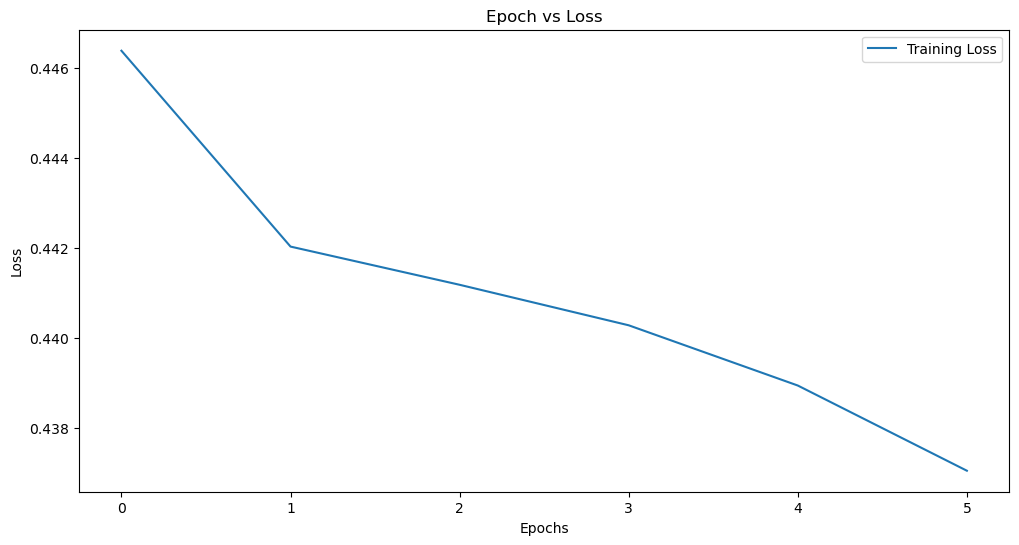

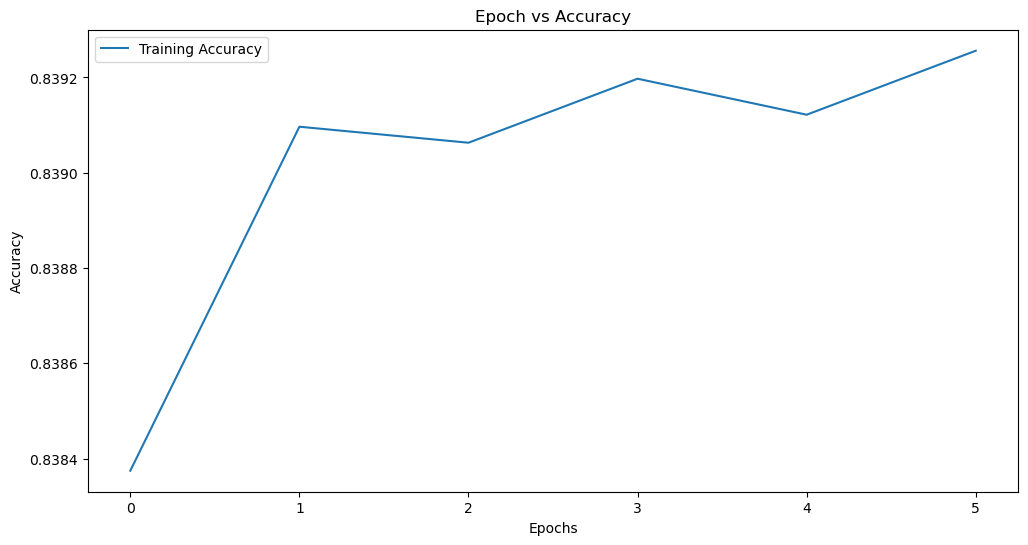

In [21]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses_per_epoch, label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies_per_epoch, label='Training Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# Save the model
torch.save(model.state_dict(), "models/two-stream_convnet.pth")